nodes.shape=(2, 6, 6, 2)


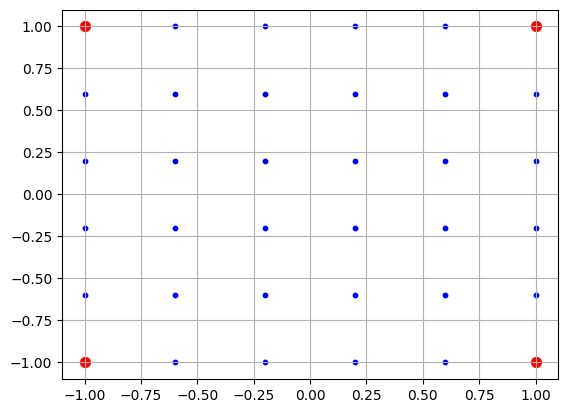

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 2
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 6
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
# depots_i = np.array([[0, 0]])
## Four depot nodes (one in each corner)
depot_indices = np.array([[0, 0], [0, n-1], [n-1, 0], [n-1,n-1]])
# depot_indices = np.array([[0, 0], [0, n-1]])
# print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depot_indices[:,0],depot_indices[:,1],0], nodes[0,depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")

cost.shape=(6, 6, 6, 6)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2421738
Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1)
    _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1)
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for i1 in range(n) for j1 in range(n))

    # Additional constraint: no loopholes!
    # _ = m.addConstrs(x[ki, i, j, i, j] == 0 for i in range(n) for j in range(n))

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)
    _ = m.addConstrs((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum() for i1, j1 in target_indices)

    # (13) Make sure target capacity doesn't change when passing through a depot
    for i, (i1, j1) in enumerate(depot_indices):
        if i == ki: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for i2, j2 in itertools.product(range(n), range(n)):
            left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))


In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
L = np.sqrt(8) * 2 # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
r = m.addMVar((n,n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)

    # (17) and (18)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)

    # (19)
    _ = m.addConstrs(r[i1,j1] - cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in depot_indices)


In [ ]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 10230 rows, 5221 columns and 43274 nonzeros
Model fingerprint: 0xa32bc737
Variable types: 37 continuous, 5184 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e+00, 3e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 2760 rows and 99 columns
Presolve time: 0.07s
Presolved: 7470 rows, 5122 columns, 40270 nonzeros
Variable types: 33 continuous, 5089 integer (2557 binary)
Found heuristic solution: objective 90.6725126
Found heuristic solution: objective 84.7336849

Root relaxation: objective 1.760240e+00, 4457 iterations, 0.34 seconds (0.50 work units)

    Nodes    |    Cur